### Imports and Environment

In [120]:
import torch as th
import pandas as pd
import gymnasium as gym
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO
import numpy as np

import collections
import gymnasium as gym
import numpy as np
import os

import tqdm

from matplotlib import pyplot as plt
from typing import Any, List, Sequence, Tuple

import pickle

import path_datatype
import sys

from env import tradingEng

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Define environment
file_path = os.path.abspath("../MarketGeneratingFunctions/1.6kRunDemo.pkl")
with open(file_path,"rb") as fp:
    paths = pickle.load(fp)
env = tradingEng(paths)

/Users/isabellebyman/opt/anaconda3/envs/exjobb/lib/python3.13/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float64
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [153]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
import importlib
import env
from env import tradingEng
importlib.reload(env) 
env = tradingEng(paths) #, action = 'small', obs = 'xs'

/Users/isabellebyman/opt/anaconda3/envs/exjobb/lib/python3.13/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float64
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


# PPO new

### Making the Agent

In [155]:
log_dir = "./logs/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir + "monitor.csv")
Nruns = 500*1
# Train PPO model
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=dict(pi=[512,512], vf=[512,512]))
#model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs,  verbose=1, batch_size=2048, n_steps=512, gamma=0.99, learning_rate=3e-4, clip_range=0.3, ent_coef=0.01, gae_lambda=0.95, vf_coef=0.5)

model = PPO("MlpPolicy", env, verbose=True, batch_size = 1024)

Using cpu device
Wrapping the env in a DummyVecEnv.


### Training the Agent + look for convergence

In [156]:
model.learn(total_timesteps=int(1e6), log_interval=2)
model.save("ppo_trading")

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 26.5          |
|    ep_rew_mean          | -14.7         |
| time/                   |               |
|    fps                  | 1657          |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 7.84701e-05   |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.83         |
|    explained_variance   | -0.0001320839 |
|    learning_rate        | 0.0003        |
|    loss                 | 14.6          |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000646     |
|    std                  | 0.995         |
|    value_loss           | 30.2          |
-------------------------------------------
--------------------------------

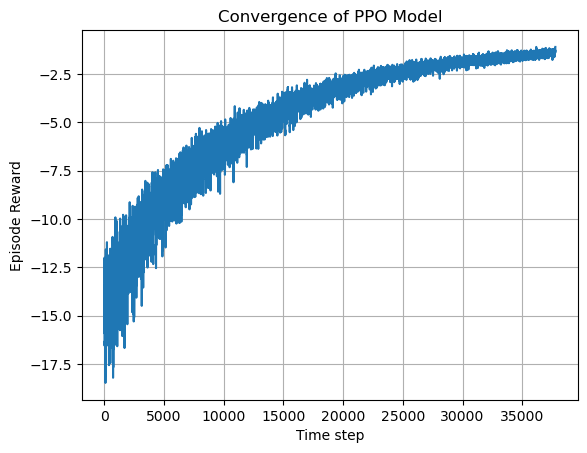

In [158]:
log_data = pd.read_csv(log_dir + "monitor.csv", skiprows=1)

plt.plot(pd.to_numeric(log_data["r"].rolling(window=10).mean()))  # "l" (length) vs "r" (reward)
plt.xlabel("Time step")
plt.ylabel("Episode Reward")
#plt.ylim(-0.0000005,0.0000005)
plt.title("Convergence of PPO Model")
plt.grid()
plt.show()

### Run a test

In [159]:
num_eval_episodes = 1

rewards_tot = list()
actions_tot = list()
pnl_tot = list()
obs, info = env.reset()
for i in range(num_eval_episodes):
    episode_over = False
    rewards = list()
    actions = list()
    pnl = list()
    obs, info = env.reset()
    while not episode_over:
        action, _states = model.predict(obs, deterministic=False)  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        actions.append(action)
        pnl.append(info['P&L'])
        episode_over = terminated or truncated
    env.close()
    rewards_tot.append(rewards)
    actions_tot.append(actions)
    pnl_tot.append(pnl)


print(f'Example action taken: {actions}')
print(f'Episode rewards: {rewards}')

Example action taken: [array([-0.48253021,  0.02685859]), array([0.4982143, 0.0408437]), array([ 0.00517831, -0.04997326]), array([-0.21377996, -0.04804822]), array([-0.29091734,  0.00251858]), array([ 0.55278265, -0.04238506]), array([-0.19330333, -0.01200204]), array([ 0.75547171, -0.06171999]), array([ 0.0207014 , -0.04188432]), array([-0.2886807 ,  0.04195687]), array([ 0.12600058, -0.01366004]), array([0.29700372, 0.00489829]), array([ 0.44848689, -0.04769374]), array([ 8.04424956e-02, -9.70619731e-05]), array([-0.25867528, -0.0591134 ]), array([-0.35677859,  0.0668415 ]), array([ 0.00387355, -0.00908123]), array([ 0.16689116, -0.00477749]), array([-0.16087569,  0.03500401]), array([ 0.30314296, -0.01331465]), array([ 0.08169502, -0.03852016]), array([ 0.4690665 , -0.01217692]), array([ 0.46596864, -0.03879432]), array([0.1321646 , 0.00594282]), array([-0.07186492,  0.02250521]), array([0.07721088, 0.06187583])]
Episode rewards: [np.float64(-0.11111095607562718), np.float64(-0.014

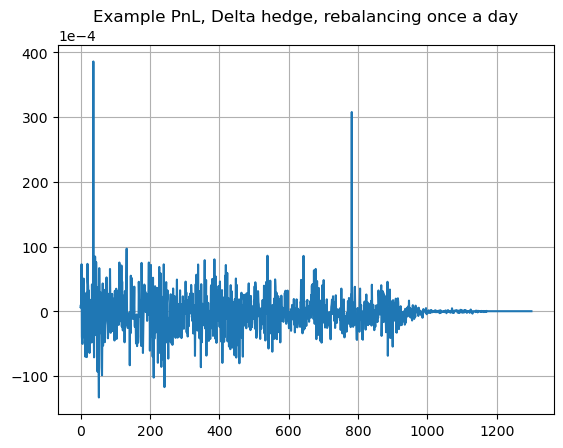

In [55]:
plt.figure(1)
plt.title("Example PnL, Delta hedge, rebalancing once a day")
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
plt.plot(pnl_tot[1])

In [54]:
np.percentile(pnl_tot[1], 5)

np.float64(-0.004446889275215954)

# PPO old

Normalized

In [56]:
log_dir = "./logs/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir + "monitor.csv")  # Properly wrapped
# Create and normalize the environment
# env = DummyVecEnv([lambda: env])
# env = VecNormalize(env, norm_obs=True, norm_reward=True)
Nruns = 500
# Train PPO model
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=dict(pi=[512,512], vf=[512,512]))
model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs,  verbose=1, batch_size=2048, n_steps=512, gamma=0.99, learning_rate=5e-3, clip_range=1.0, ent_coef=0.01, gae_lambda=1.0, vf_coef=0.5)
model.learn(total_timesteps=252*Nruns, log_interval=2)

# Save model and normalization stats
model.save("ppo_trading")


Using cpu device


/Users/isabellebyman/opt/anaconda3/envs/exjobb/lib/python3.13/site-packages/stable_baselines3/ppo/ppo.py:148: UserWarning: You have specified a mini-batch size of 2048, but because the `RolloutBuffer` is of size `n_steps * n_envs = 512`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 512
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=512 and n_envs=1)
  warnings.warn(


-----------------------------------------
| time/                   |             |
|    fps                  | 787         |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 2.8869712   |
|    clip_fraction        | 0.182       |
|    clip_range           | 1           |
|    entropy_loss         | -25.7       |
|    explained_variance   | -0.10431838 |
|    learning_rate        | 0.005       |
|    loss                 | -0.75       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.375      |
|    std                  | 1.01        |
|    value_loss           | 4.65        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 740         |
|    iterations           | 4           |
|    time_elapsed         | 2     

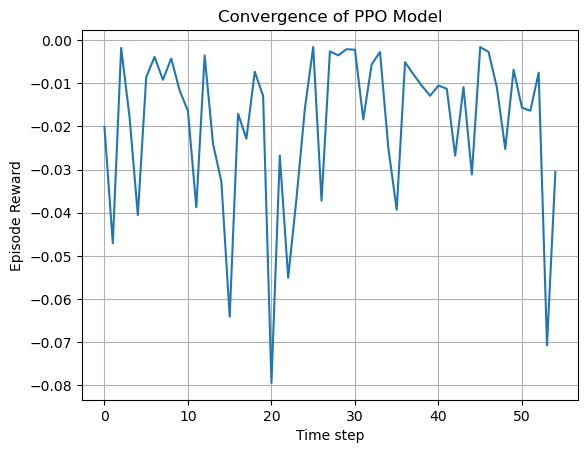

In [5]:
log_data = pd.read_csv(log_dir + "monitor.csv", skiprows=1)

plt.plot(log_data["r"])  # "l" (length) vs "r" (reward)
plt.xlabel("Time step")
plt.ylabel("Episode Reward")
plt.title("Convergence of PPO Model")
plt.grid()
plt.show()

### Training the Agent

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 2.27e+03       |
|    ep_rew_mean          | -1.54e+04      |
| time/                   |                |
|    fps                  | 738            |
|    iterations           | 2              |
|    time_elapsed         | 5              |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | 0.018740967    |
|    clip_fraction        | 0.0446         |
|    clip_range           | 0.3            |
|    entropy_loss         | -25.6          |
|    explained_variance   | -4.4941902e-05 |
|    learning_rate        | 3e-05          |
|    loss                 | 6.49           |
|    n_updates            | 10             |
|    policy_gradient_loss | -0.0123        |
|    std                  | 1.01           |
|    value_loss           | 1.5e+04        |
--------------------------------------------
----------

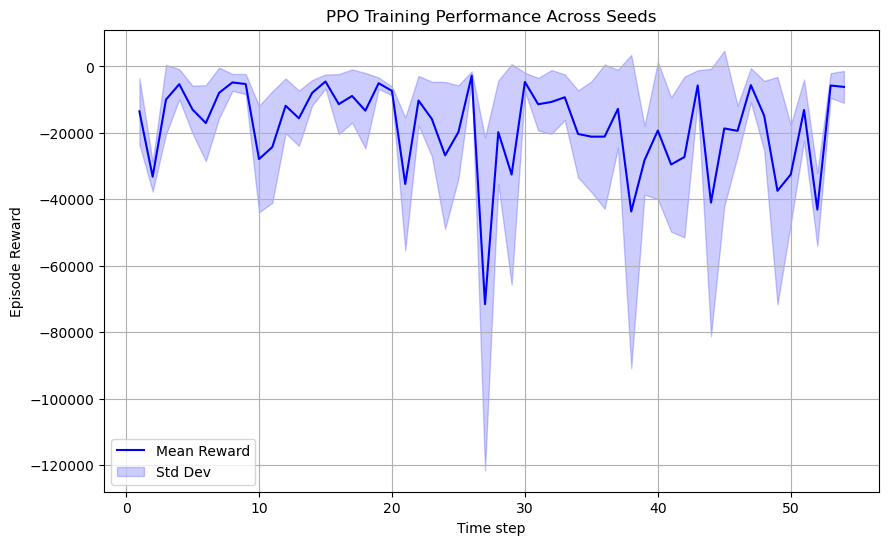

In [168]:
Nruns = 500  # Define how many runs per seed

all_rewards = []  #c Store rewards for each seed

for i in range(3):
    model.learn(total_timesteps=252 * Nruns, log_interval=2)

    # Load monitor data for this seed
    log_data = pd.read_csv(log_dir + "monitor.csv", skiprows=1)
    
    # Store rewards
    all_rewards.append(log_data["r"].values)  # Ensure rewards are saved in a list
    
    env = Monitor(env, log_dir + "monitor.csv")  # Save log file
# Convert to numpy array for easier manipulation
all_rewards = np.array(all_rewards)

# Compute mean and standard deviation across seeds
mean_rewards = np.mean(all_rewards, axis=0)
std_rewards = np.std(all_rewards, axis=0)

# Time steps (assuming sequential logging)
time_steps = np.arange(len(mean_rewards))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_steps, mean_rewards, label="Mean Reward", color="blue")
plt.fill_between(time_steps, mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2, color="blue", label="Std Dev")

plt.xlabel("Time step")
plt.ylabel("Episode Reward")
plt.title("PPO Training Performance Across Seeds")
plt.legend()
plt.grid()
plt.show()


In [189]:
Nruns = 500
model.learn(total_timesteps=252*Nruns, log_interval=2) # exploration_fraction=0.2 Runs in total total_timesteps. After every n_steps, update the policy. Makes decision based on batch_size.
model.save("ppo_fin")

----------------------------------------
| time/                   |            |
|    fps                  | 940        |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 1024       |
| train/                  |            |
|    approx_kl            | 0.27279052 |
|    clip_fraction        | 0.0865     |
|    clip_range           | 1          |
|    entropy_loss         | -25.5      |
|    explained_variance   | 0.16625553 |
|    learning_rate        | 0.005      |
|    loss                 | -0.382     |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0915    |
|    std                  | 0.996      |
|    value_loss           | 0.283      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 825         |
|    iterations           | 4           |
|    time_elapsed         | 2           |
|    total_

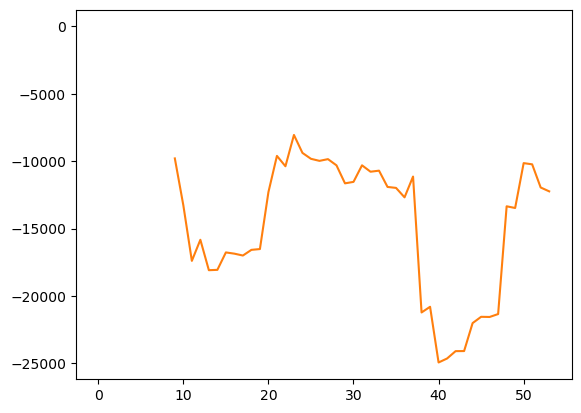

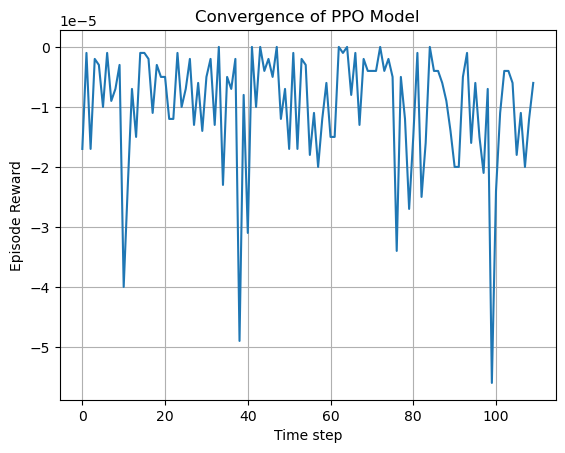

In [190]:
log_data = pd.read_csv(log_dir + "monitor.csv", skiprows=1)
window = 50
#smoothed_rewards = log_data["r"].rolling(window).mean()
smoothed_rewards = pd.Series(all_rewards[0][:-1]).rolling(window=10).mean()
#plt.ylim(-0.00002,0)
plt.plot(1)
plt.plot(smoothed_rewards)
plt.show()

plt.plot(log_data["r"])  # "l" (length) vs "r" (reward)
plt.xlabel("Time step")
plt.ylabel("Episode Reward")
plt.title("Convergence of PPO Model")
plt.grid()
plt.show()



In [ ]:
# vecnormalized
episode_over = False
rewards = list()
actions = list()
pnl = list()
obs = env.reset()
i = 0
while not episode_over:
    action, _states = model.predict(obs, deterministic=False)  # replace with actual agent
    obs, reward, terminated, truncated = env.step(action)
    rewards.append(reward[0])
    actions.append(action)
    pnl.append(info['P&L'])
    episode_over = terminated[0] or truncated[0]['TimeLimit.truncated']


rewards


### Run a test

In [259]:
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
num_eval_episodes = 1

episode_over = False
rewards = list()
actions = list()
pnl = list()
obs = env.reset()
while not episode_over:
    action, _states = model.predict(obs, deterministic=False)  # replace with actual agent
    obs, reward, terminated, truncated = env.step(action)
    rewards.append(reward)
    actions.append(action)
    # pnl.append(info['P&L'])
    episode_over = terminated or truncated
# env.close()

print(f'Example action taken: {actions}')
print(f'Episode rewards: {rewards}')

Example action taken: [array([[ 1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,
         1.,  1., -1., -1.,  1.]], dtype=float32)]
Episode rewards: [array([-5.19235348e-05])]


In [17]:
num_eval_episodes = 10

rewards_tot = list()
actions_tot = list()
pnl_tot = list()
obs, info = env.reset()
for i in range(num_eval_episodes):
    episode_over = False
    rewards = list()
    actions = list()
    pnl = list()
    obs, info = env.reset()
    while not episode_over:
        action, _states = model.predict(obs, deterministic=False)  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        actions.append(action)
        pnl.append(info['P&L'])
        episode_over = terminated or truncated
    # env.close()
    rewards_tot.append(rewards)
    actions_tot.append(actions)
    pnl_tot.append(pnl)

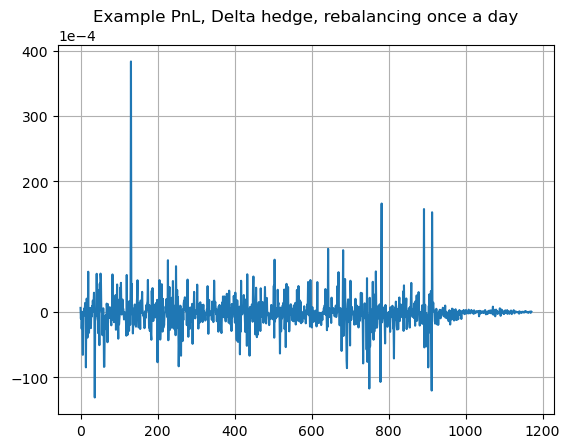

In [143]:
plt.figure(1)
plt.title("Example PnL, Delta hedge, rebalancing once a day")
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
plt.plot(pnl_tot[9])

In [18]:
np.mean([np.percentile(i, 5) for i in pnl_tot])

np.float64(-0.0027407521662838152)

In [ ]:
def pnl_cva(path):
    pnl_without_hedge = np.zeros(len(path.CVA)-1)
    for i in range(1, len(path.CVA)):
        pnl_without_hedge[i-1] = path.CVA[i]-path.CVA[i-1]
    return pnl_without_hedge

pnl_without_hedge = [None]*len(paths)
for i in range(len(pnl_without_hedge)):
    pnl_without_hedge[i] = pnl_cva(paths[i])

plt.figure(2)
# Extract the 5% worst percentile values from each array
var_values_no_hedge = np.array([np.percentile(p,5) for p in pnl_without_hedge]) # is this really VaR?

var_values_no_hedge

## Try last year's

In [73]:
from stable_baselines3 import PPO

policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=dict(pi=[512,512], vf=[512,512]))

model = PPO("MlpPolicy", env, policy_kwargs = policy_kwargs, verbose=1)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [74]:
Nruns = 900
model.learn(total_timesteps=2520*Nruns, log_interval=20) # exploration_fraction=0.2
model.save("ppo_fin")

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.17e+03    |
|    ep_rew_mean          | -4.29e-06   |
| time/                   |             |
|    fps                  | 439         |
|    iterations           | 20          |
|    time_elapsed         | 93          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.009098293 |
|    clip_fraction        | 0.07        |
|    clip_range           | 0.2         |
|    entropy_loss         | -25         |
|    explained_variance   | 0.8801881   |
|    learning_rate        | 0.0003      |
|    loss                 | -0.017      |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00726    |
|    std                  | 0.973       |
|    value_loss           | 2.82e-05    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

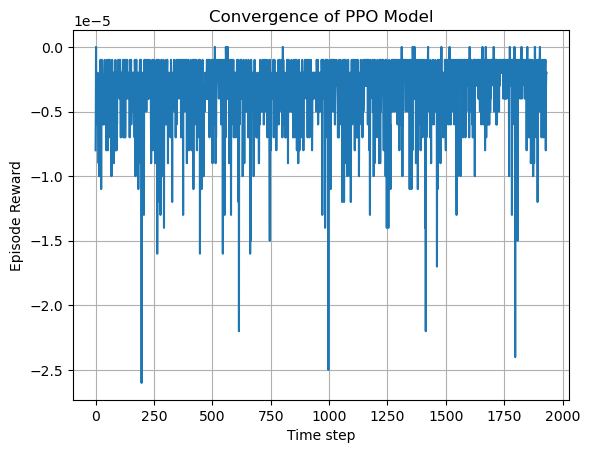

In [75]:
log_data = pd.read_csv(log_dir + "monitor.csv", skiprows=1)

# Plot the convergence curve
plt.plot(log_data["r"])  # "l" (length) vs "r" (reward)
plt.xlabel("Time step")
plt.ylabel("Episode Reward")
plt.title("Convergence of PPO Model")
plt.grid()
plt.show()

# New policy

In [105]:
# === FILE: ppo_quantile_policy.py ===

import torch
import torch.nn as nn
from stable_baselines3.ppo.policies import ActorCriticPolicy
from stable_baselines3.common.torch_layers import MlpExtractor

class QuantileValueHead(nn.Module):
    def __init__(self, input_dim, n_quantiles=51):
        super().__init__()
        self.quantile_layer = nn.Linear(input_dim, n_quantiles)

    def forward(self, x):
        return self.quantile_layer(x)  # [batch_size, n_quantiles]

class PPOQuantilePolicy(ActorCriticPolicy):
    def __init__(self, observation_space, action_space, lr_schedule, *args, n_quantiles=51, **kwargs):
        self.n_quantiles = n_quantiles
        self.training_step = 0
        super().__init__(observation_space, action_space, lr_schedule, *args, **kwargs)
        self.quantile_value_net = QuantileValueHead(self.mlp_extractor.latent_dim_vf, n_quantiles)
        self._build(lr_schedule=lr_schedule)  # ✅ Now this works


    def evaluate_actions(self, obs, actions):
        features = self.extract_features(obs)
        latent_pi, latent_vf = self.mlp_extractor(features)
        dist = self._get_action_dist_from_latent(latent_pi)
        log_prob = dist.log_prob(actions)
        entropy = dist.entropy()
        quantiles = self.quantile_value_net(latent_vf)  # [batch, n_quantiles]
        if self.training_step < 1000000:  # about ~1M env steps
            value_estimate = quantiles.mean(dim=1, keepdim=True)
        else:
            value_estimate = quantiles.quantile(0.05, dim=1, keepdim=True)  # shape: [batch, 1]
        return log_prob, entropy, value_estimate

    def forward(self, obs, deterministic=False):
        features = self.extract_features(obs)
        latent_pi, latent_vf = self.mlp_extractor(features)
        dist = self._get_action_dist_from_latent(latent_pi)
        actions = dist.get_actions(deterministic=deterministic)
        log_prob = dist.log_prob(actions)
        quantiles = self.quantile_value_net(latent_vf)
        if self.training_step < 1000000:  # about ~1M env steps
            value_estimate = quantiles.mean(dim=1, keepdim=True)
        else:
            value_estimate = quantiles.quantile(0.05, dim=1, keepdim=True)  # shape: [batch, 1]
        return actions, log_prob, value_estimate

# === FILE: ppo_quantile.py ===

import torch
from stable_baselines3.ppo import PPO
from torch.nn import functional as F

class PPOQuantile(PPO):
    def __init__(self, *args, n_quantiles=51, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_quantiles = n_quantiles
        self.taus = torch.linspace(0.01, 0.99, n_quantiles).to(self.device)

    def quantile_huber_loss(self, preds, targets, taus, k=1.0):
        u = targets.unsqueeze(1) - preds  # [batch, n_quantiles]
        huber = torch.where(u.abs() < k, 0.5 * u.pow(2), k * (u.abs() - 0.5 * k))
        weights = (taus - (u.detach() < 0).float()).abs()
        return (weights * huber).mean()

    def _loss_critic(self, values, value_targets):
        return self.quantile_huber_loss(values, value_targets, self.taus)

# === FILE: train_quantile_ppo.py ===

import os
import torch as th
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor

log_dir = "./logs/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir + "monitor.csv")

# Policy architecture
policy_kwargs = dict(
    activation_fn=th.nn.ReLU,
    net_arch=dict(pi=[64, 64], vf=[64, 64]),
    n_quantiles=51
)

# Create and train model
model = PPOQuantile(
    PPOQuantilePolicy, env,
    policy_kwargs=policy_kwargs,
    verbose=1,
    batch_size=1024,
    n_steps=512, #1024,
    gamma=0.99,
    gae_lambda=0.98,
    learning_rate=1e-4,
    clip_range=0.1,
    ent_coef=0.005,
    vf_coef=1.0
)

Nruns = 500 * 10
model.learn(total_timesteps=252 * Nruns, log_interval=2)
model.save("ppo_quantile_model")


Using cpu device
Wrapping the env in a DummyVecEnv.


/Users/isabellebyman/opt/anaconda3/envs/exjobb/lib/python3.13/site-packages/stable_baselines3/ppo/ppo.py:148: UserWarning: You have specified a mini-batch size of 1024, but because the `RolloutBuffer` is of size `n_steps * n_envs = 512`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 512
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=512 and n_envs=1)
  warnings.warn(


--------------------------------------------
| time/                   |                |
|    fps                  | 1843           |
|    iterations           | 2              |
|    time_elapsed         | 0              |
|    total_timesteps      | 1024           |
| train/                  |                |
|    approx_kl            | 123278310000.0 |
|    clip_fraction        | 1              |
|    clip_range           | 0.1            |
|    entropy_loss         | 0.013          |
|    explained_variance   | -1.1284211     |
|    learning_rate        | 0.0001         |
|    loss                 | 4.6e+10        |
|    n_updates            | 10             |
|    policy_gradient_loss | 4.63e+10       |
|    std                  | 0.999          |
|    value_loss           | 111            |
--------------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 1716           |
|    itera

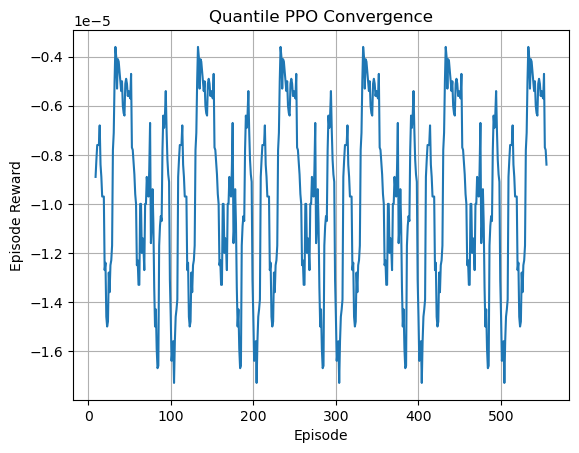

In [109]:
# Plot rewards
log_data = pd.read_csv(log_dir + "monitor.csv", skiprows=1, on_bad_lines="skip")
plt.plot(pd.to_numeric(log_data["r"].rolling(window=10).mean()))
plt.xlabel("Episode")
#plt.ylim(-0.08,0)
plt.ylabel("Episode Reward")
plt.title("Quantile PPO Convergence")
plt.grid()
plt.show()

In [107]:
num_eval_episodes = 1

episode_over = False
rewards = list()
actions = list()
pnl = list()
obs, info = env.reset()
while not episode_over:
    action, _states = model.predict(obs, deterministic=True)  
    obs, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    actions.append(action)
    pnl.append(info['P&L'])
    episode_over = terminated or truncated


print(f'Example action taken: {actions}')
print(f'Episode rewards: {rewards}')

env.close()



Example action taken: [array([ 0.30761153, -0.14899391,  0.4394948 ,  0.20816258,  0.05817534,
       -0.49366835, -0.04844988,  0.49784857, -0.12376665,  0.5513216 ,
       -0.6970351 ,  0.01674458,  0.46160185, -0.16670278, -0.37086076,
        0.4980037 ,  0.09132458, -0.422111  ], dtype=float32), array([ 0.29649186, -0.14253624,  0.4220339 ,  0.20036715,  0.05444024,
       -0.47689635, -0.04754362,  0.4795325 , -0.11971146,  0.53099835,
       -0.670675  ,  0.01678143,  0.4445326 , -0.16126584, -0.35971346,
        0.47993484,  0.08718691, -0.40692917], dtype=float32), array([ 0.29662797, -0.14261046,  0.42224506,  0.20046498,  0.05447627,
       -0.47713065, -0.04757397,  0.47976834, -0.11976779,  0.53127205,
       -0.6710209 ,  0.01678177,  0.4447511 , -0.1613384 , -0.35987526,
        0.48016977,  0.08723304, -0.40713924], dtype=float32), array([ 0.29654303, -0.14255692,  0.42210096,  0.20039994,  0.05444384,
       -0.47696787, -0.04755415,  0.47961003, -0.11972682,  0.531074